In [316]:
import cv2 as cv
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from ellipse import LsqEllipse
from helpers import *

In [317]:
def findSeed(img: np.ndarray):
    ksize = min(img.shape)//5
    kernel = np.ones((ksize, ksize), np.float32)/(ksize**2)
    im = img.astype(np.float32)
    dst = cv.filter2D(im, -1, kernel)
    _, _, minLoc, _ = cv.minMaxLoc(dst)
    return minLoc

In [318]:
def fitEllipse(X1, X2):
    X = np.array(list(zip(X1, X2)))
    reg = LsqEllipse().fit(X)
    return reg.as_parameters()

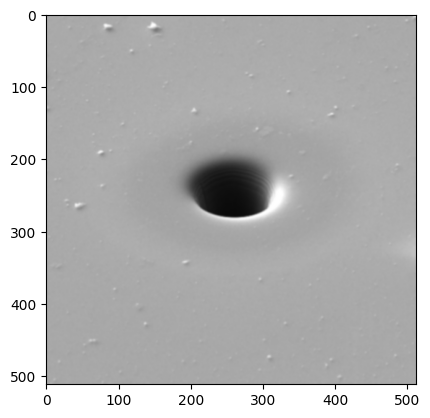

In [319]:
path = "data/finalizace - FIB spots/122-0007X manual 5s/_2022_122-0007 S8252X, US_images_FIB_Spots_EV_test_300nA.png"
path = path.strip()
img = load_image(path)
img = cv.GaussianBlur(img, (5, 5), 0)
plt.imshow(cv.cvtColor(img, cv.COLOR_GRAY2RGB))

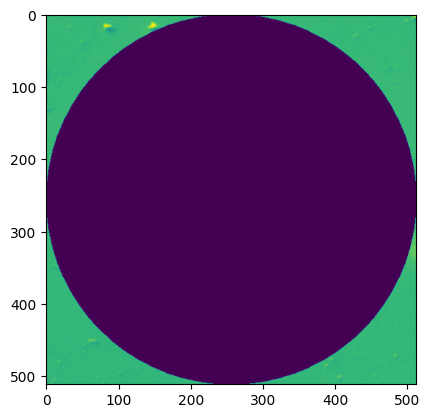

In [320]:
# find background mean and standard deviation
center = (img.shape[1]//2, img.shape[0]//2)

# filter part of the image, where only background should be
ellipseMask = np.zeros_like(img, dtype=np.uint8)
ellipseMask = cv.ellipse(ellipseMask, center, center, 0, 0, 360, 255, -1)
ellipseMaskInv = np.bitwise_not(ellipseMask).astype(np.uint8)
background = np.bitwise_and(img, ellipseMaskInv)
plt.imshow(background)

640.95


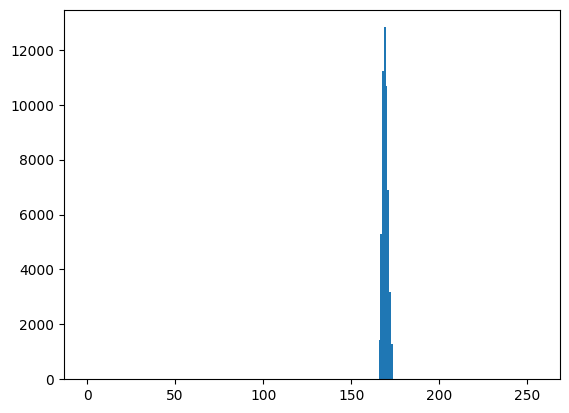

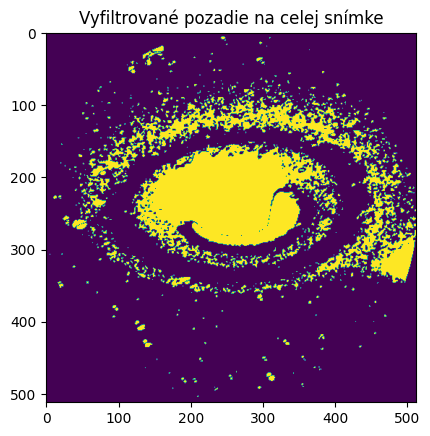

In [321]:
# calculate its characteristics
counts, bins = np.histogram(background, 256, [0, 256])
counts[0] = 0
thresh = max(counts) / 20
print(thresh)
counts[counts < thresh] = 0
plt.bar(range(0, 256), counts, 1)
plt.show()
probs = counts / np.sum(counts)
vals = list(range(256))
mean = np.sum(probs * vals)
sd = np.sqrt(np.sum(probs * (vals - mean)**2))

# mask out where the background should be
mask = np.logical_or(img > (mean+sd*3), img < mean-sd*3)
mask = mask.astype(np.uint8)

# filter out background to reduce noise
mask = np.logical_and(mask, ellipseMask).astype(np.uint8)

# further remove noise (values are 1 or 0, if pixel does not have enough neighbours, the value will be rounded to 0)
plt.title("Vyfiltrované pozadie na celej snímke")
plt.imshow(mask)
plt.show()

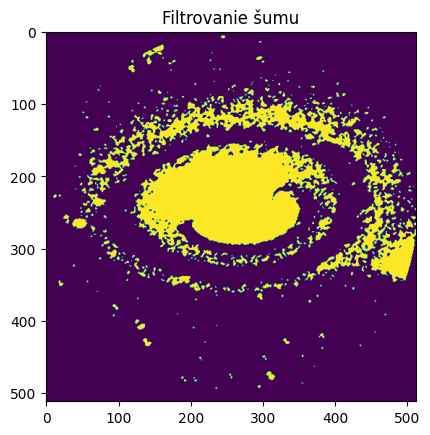

In [322]:
amask = cv.medianBlur(mask, 3)
plt.title("Filtrovanie šumu")
plt.imshow(amask)
plt.show()

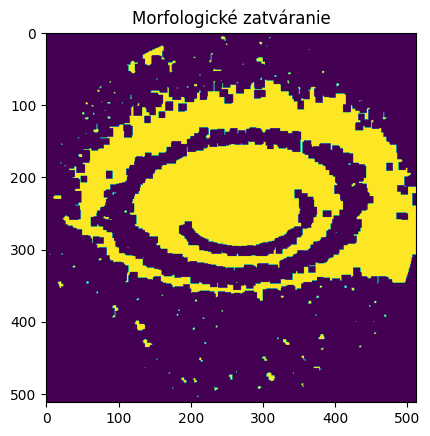

In [323]:
mmask = cv.morphologyEx(mask, cv.MORPH_CLOSE, np.ones((7, 7)))
plt.title("Morfologické zatváranie")
plt.imshow(mmask)
plt.show()

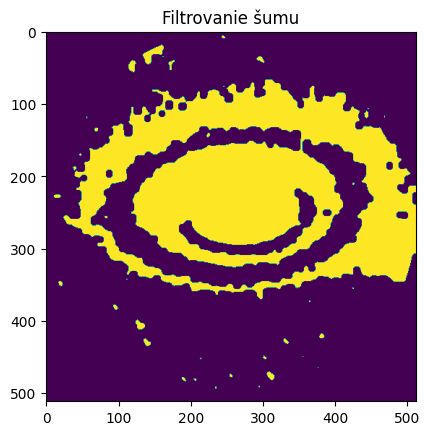

In [324]:
bmask = cv.medianBlur(mmask, 5)
plt.title("Filtrovanie šumu")
plt.imshow(bmask)
plt.show()

(374, 165)


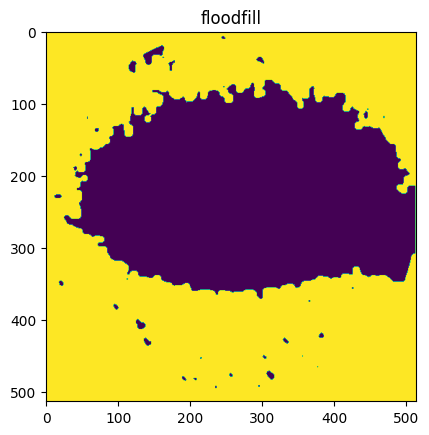

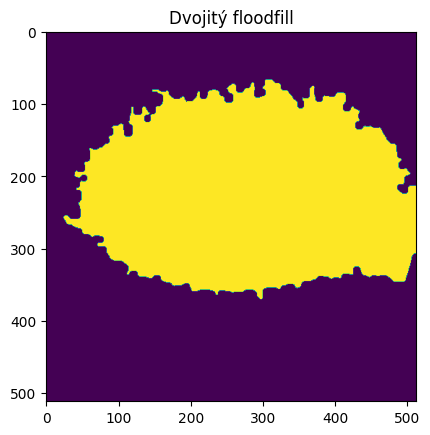

In [325]:
# close and double floodfill to hopefuly extract only the hole
ffmask = np.zeros_like(bmask, dtype=np.uint8)
ffmask = np.zeros((bmask.shape[0]+2, bmask.shape[1]+2), dtype=np.uint8)
cv.floodFill(bmask, ffmask, (0, 0), 1, flags=cv.FLOODFILL_MASK_ONLY)
# mask = np.invert(ffmask)
fmask2 = np.zeros_like(ffmask)
seed = findSeed(ffmask)
print(seed)
plt.title("floodfill")
plt.imshow(ffmask)
plt.show()
cv.floodFill(ffmask[1:-1, 1:-1], fmask2, seed, 1, flags=cv.FLOODFILL_MASK_ONLY)
fmask2 = fmask2[1:-1, 1:-1]

plt.title("Dvojitý floodfill")
plt.imshow(fmask2)
plt.show()

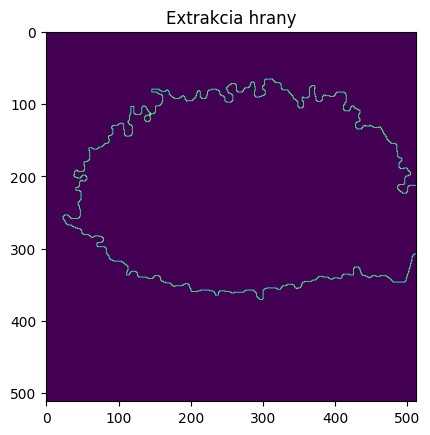

In [326]:
dilated = cv.morphologyEx(fmask2, cv.MORPH_DILATE, np.ones((3, 3)))
edge = dilated - fmask2
plt.title("Extrakcia hrany")
plt.imshow(edge)
plt.show()

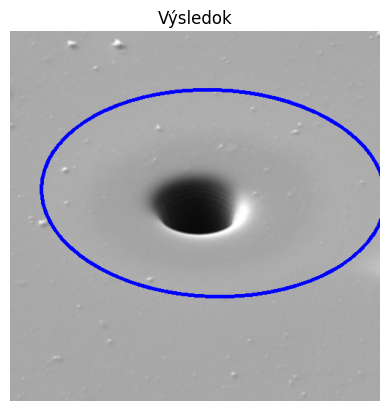

In [327]:
a, b = np.nonzero(edge)
params = fitEllipse(b, a)
elimg = draw_ellipse(cv.cvtColor(img, cv.COLOR_GRAY2BGR), *params)
plt.title("Výsledok")
plt.imshow(elimg)
plt.axis('off')
plt.show()

[281 224]


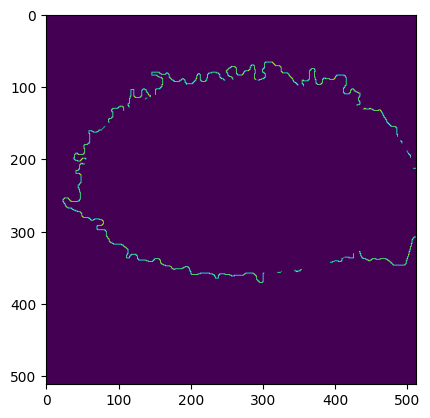

In [328]:
center, width, height, phi = params
c = np.rint(center).astype(int)
a = np.rint((width-10, height-10)).astype(int)
print(c)
toDraw = edge.copy()
aaa = cv.ellipse(toDraw, c, a, np.rad2deg(phi),0,360,0,-1)
plt.imshow(toDraw)



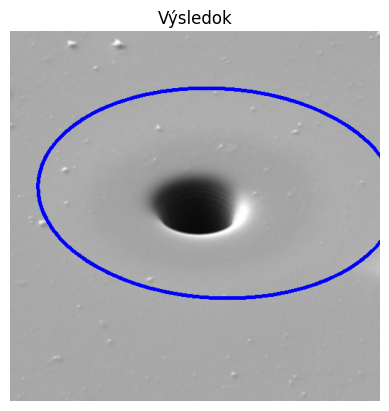

In [329]:
a, b = np.nonzero(toDraw)
params = fitEllipse(b, a)
nimg = draw_ellipse(cv.cvtColor(img, cv.COLOR_GRAY2BGR), *params)
plt.title("Výsledok")
plt.imshow(nimg)
plt.axis('off')
plt.show()